# Financial and Business News Analysis

This report presents an exploratory analysis of financial and business news articles. The study involves data cleaning, extracting named entities from the text, and performing sentiment analysis to understand the overall tone of the news.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm


# 1. Data Cleaning

Before analyzing the news content, the text data is preprocessed to remove unnecessary elements:

In [3]:
df = pd.read_csv("News urls - Sheet1.csv")

In [4]:
import re  # Import the regex module

# Function to clean text
def clean_text(text):
    if isinstance(text, str):  # Ensure input is a string
        text = re.sub(r'\n+', ' ', text)  # Remove newlines
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text.lower()  # Convert to lowercase
    return ""

# Apply cleaning function to all text columns
text_columns = df.select_dtypes(include=["object"]).columns  # Select all text columns

for col in text_columns:
    df[col] = df[col].apply(clean_text)  # Apply cleaning function to each column


# 2. NER

Named Entity Recognition (NER) is performed to extract key entities from the news articles. These entities include:
- **Companies** (e.g., Tesla, Microsoft)
- **Financial terms** (e.g., GDP, inflation)
- **Geopolitical entities** (e.g., China, European Union)

In [153]:
from transformers import pipeline
from collections import Counter

# Load the NER model
ner_model = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", aggregation_strategy="simple")

# Counter to track the occurrences of all NER entities
entity_counter = Counter()
ner_entities = []

# Iterate through all text samples and extract NER entities
for idx, text_sample in enumerate(df["news"].astype(str)):  # Convert to string to avoid errors
    ner_results = ner_model(text_sample)  # Extract entities using the NER model
    entities = [entity['word'] for entity in ner_results]  # Extract entity names
    ner_entities.append(", ".join(entities))  # Store entities as a comma-separated string
    for entity in entities:
        entity_counter[entity] += 1  # Count entity occurrences

    # Print progress every 10 articles
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(df)} articles...")

# Add NER results as a new column
df["NER_entities"] = ner_entities


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processed 10/337 articles...
Processed 20/337 articles...
Processed 30/337 articles...
Processed 40/337 articles...
Processed 50/337 articles...
Processed 60/337 articles...
Processed 70/337 articles...
Processed 80/337 articles...
Processed 90/337 articles...
Processed 100/337 articles...
Processed 110/337 articles...
Processed 120/337 articles...
Processed 130/337 articles...
Processed 140/337 articles...
Processed 150/337 articles...
Processed 160/337 articles...
Processed 170/337 articles...
Processed 180/337 articles...
Processed 190/337 articles...
Processed 200/337 articles...
Processed 210/337 articles...
Processed 220/337 articles...
Processed 230/337 articles...
Processed 240/337 articles...
Processed 250/337 articles...
Processed 260/337 articles...
Processed 270/337 articles...
Processed 280/337 articles...
Processed 290/337 articles...
Processed 300/337 articles...
Processed 310/337 articles...
Processed 320/337 articles...
Processed 330/337 articles...


In [154]:
# Save results to a new CSV file
df.to_csv("NER_processed_news.csv", index=False)

## 2.1  Word Cloud

A **word cloud** visualization is generated to highlight the most frequently occurring words in the dataset. This provides an overview of the dominant topics in the news articles.

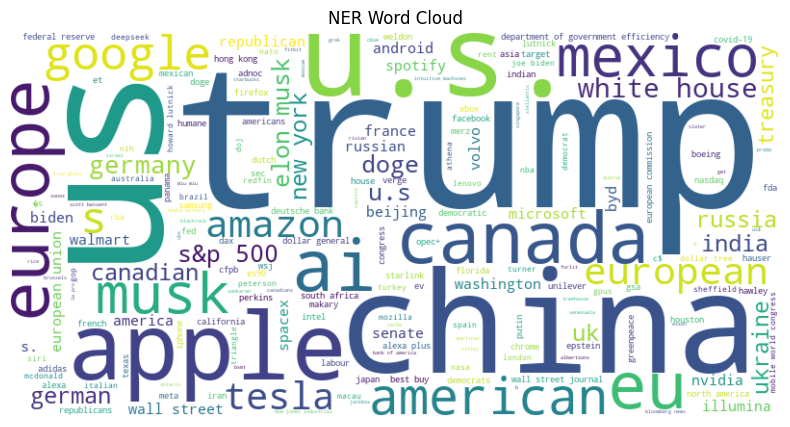

In [262]:
# Define a set of stop words (words you want to exclude)
stop_words = set([
    "wall", "street", "u", "x", "bloomberg", "donald trump", "united states","u . s .",".", "�", "x",' u.s.', ' u','chinese'
])

# Function to clean entity names
def clean_entity(entity):
    entity = entity.lower().strip()  # Convert to lowercase and remove leading/trailing spaces
    entity = re.sub(r"\.", "", entity)
    entity = re.sub(r"[^a-zA-Z0-9\s]", "", entity)  # Remove other special characters
    return entity if entity not in stop_words and entity else None  # Exclude stop words and empty entities

# Clean the entity counter by removing unwanted words
cleaned_entity_counter = {entity: count for entity, count in entity_counter.items() if clean_entity(entity)}

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(cleaned_entity_counter)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("NER Word Cloud")
plt.show()


In [207]:
# Function to clean NER entities
def clean_entities(entity_string):
    if isinstance(entity_string, str):  # Ensure it's a string
        entities = entity_string.split(",")  # Split into list
        entities = [e.strip() for e in entities]  # Remove extra spaces
        entities = [e for e in entities if len(e) > 1 and e not in [".", "�", "x"]]  # Remove unwanted symbols and short entities
        entities = list(set(entities))  # Remove duplicates
        return ", ".join(entities)  # Join back into a string
    return ""

# Apply cleaning to the NER_entities column
df["NER_entities_new"] = df["NER_entities"].apply(clean_entities)

## 2.2 NER Network

A **NER entity network** is constructed to map the relationships between extracted entities. This helps in understanding connections between companies, key financial indicators, and market events.

Top selected entities (after filtering stop words): [' trump', ' us', ' china', ' apple', ' canada', ' ai', ' donald trump', ' europe', ' eu', ' mexico', ' american', ' google', ' european', ' amazon', ' tesla', ' white house', ' germany', ' doge', ' elon musk', ' s&p 500', ' canadian', ' uk', ' india', ' german', ' russia', ' new york', ' ukraine', ' treasury', ' republican', ' wall street', ' beijing', ' walmart', ' nvidia', ' spacex', ' illumina', ' european union', ' washington', ' android', ' france', ' russian', ' spotify', ' senate', ' america', ' biden', ' microsoft', ' byd', ' volvo', ' department of government efficiency', ' cfpb', ' best buy']


Text(0.5, 1.0, 'NER Relationship Graph (Top 50 Entities)')

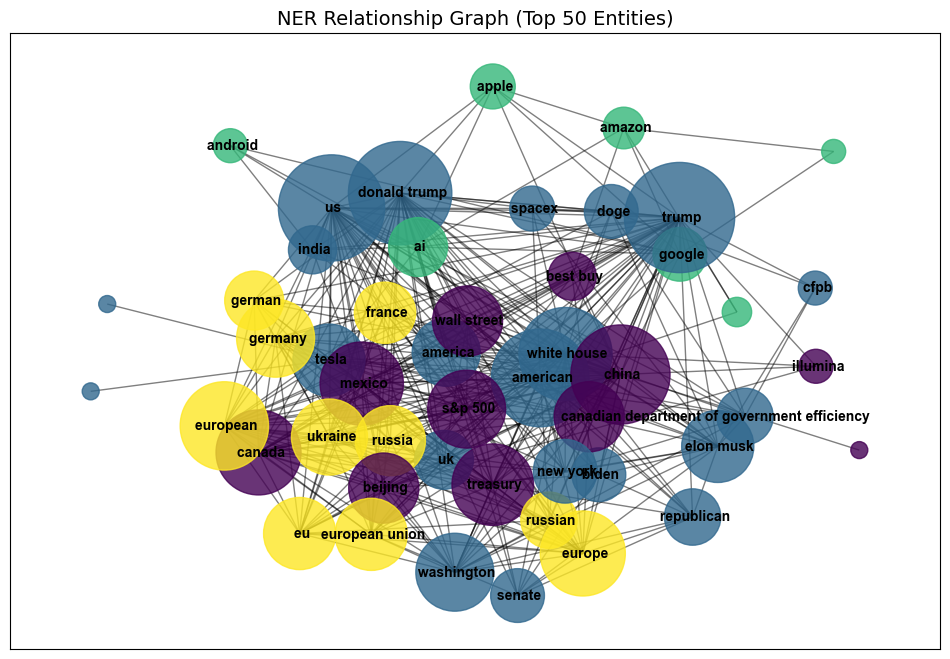

In [282]:
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community # Correct import for Louvain method

# Define thresholds
min_co_occurrence = 3  # Minimum co-occurrence count
top_n_entities = 50

# Define unwanted entities (stopwords)
stop_entities = {"s",  ".", ",", "-", "?", "d", "r", "k", "wsj", "c", "bloomberg", "4", "pe", "crew",
                 "verge", "robbmstewart", "rent", "anthony", "harrup", "an", "cs", "com", "-led", "f", "5", "1",
                 "sc", "r-ia", "g",' chinese',' u.s.', ' u',' u.s', 's.',' bloomberg',' musk',' x'}


# **Step 1: Filter out stop words before selecting the top entities**
filtered_entity_counter = {
    entity: count for entity, count in entity_counter.items()
    if entity.lower() not in stop_entities and len(entity) > 1 and not entity.isdigit()
}

top_entities = [
    entity for entity, count in sorted(filtered_entity_counter.items(), key=lambda x: x[1], reverse=True)[:top_n_entities]
]

print("Top selected entities (after filtering stop words):", top_entities)  # Debugging print


# Create graph
G = nx.Graph()

# **Step 2: Build the network using only the top 100 entities**
for entity_list in df["NER_entities"]:
    entities = entity_list.split(", ")
    selected_entities = set(entities) & set(top_entities)  # Keep only top N entities

    for entity1 in selected_entities:
        for entity2 in selected_entities:
            if entity1 != entity2:
                if G.has_edge(entity1, entity2):
                    G[entity1][entity2]["weight"] += 1
                else:
                    G.add_edge(entity1, entity2, weight=1)

# **Step 3: Remove weak edges**
edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w["weight"] < min_co_occurrence]
G.remove_edges_from(edges_to_remove)

# **Step 4: Remove isolated nodes (entities with no remaining connections)**
nodes_to_remove = list(nx.isolates(G))
G.remove_nodes_from(nodes_to_remove)

# **Apply community detection (Louvain algorithm)**
partition = community.best_partition(G) # Assigns a community ID to each node

# **Step 5: Use a visually appealing layout**
pos = nx.kamada_kawai_layout(G)  # Alternative to spring_layout for better spacing

# **Step 6: Draw the network with community colors**
plt.figure(figsize=(12, 8))
node_color = [partition[node] for node in G.nodes()]  # Color nodes by community
node_sizes = [G.degree(n) * 150 for n in G.nodes()]  # Scale node size by importance

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_color, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# **Improve label readability (show only the most connected nodes)**
high_degree_nodes = [node for node in G.nodes if G.degree(node) > 3]  # Label only highly connected nodes
labels = {node: node for node in high_degree_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_family="Arial", font_weight="bold")

# **Step 7: Show the final plot**
plt.title(f"NER Relationship Graph (Top {top_n_entities} Entities)", fontsize=14)


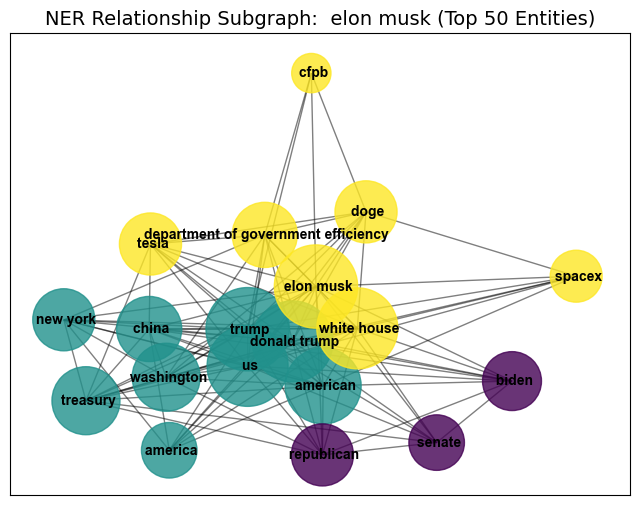

In [284]:
# Check if "elon musk" is in the graph
target_entity = ' elon musk'


# **Step 2: Ensure "elon musk" exists in the graph**
if target_entity in G.nodes:
    # **Extract all entities directly connected to "elon musk"**
    related_nodes = list(G.neighbors(target_entity))  # Get all directly connected entities

    # **Step 3: Sort nodes by degree (importance) and keep only the top 50**
    top_related_nodes = sorted(related_nodes, key=lambda node: G.degree(node), reverse=True)[:top_k]

    # **Step 4: Ensure "elon musk" is included in the subgraph**
    top_related_nodes.append(target_entity)

    # **Step 5: Create a subgraph with only these top 50 entities**
    subgraph = G.subgraph(top_related_nodes)

    # **Step 6: Apply community detection on the subgraph**
    sub_partition = community.best_partition(subgraph)

    # **Step 7: Use a visually appealing layout**
    sub_pos = nx.spring_layout(subgraph)  # Alternative: nx.kamada_kawai_layout(subgraph)

    # **Step 8: Draw the subgraph**
    plt.figure(figsize=(8, 6))
    sub_node_color = [sub_partition[node] for node in subgraph.nodes()]
    sub_node_sizes = [subgraph.degree(n) * 200 for n in subgraph.nodes()]  # Scale node size by connectivity

    nx.draw_networkx_nodes(subgraph, sub_pos, node_size=sub_node_sizes, node_color=sub_node_color, cmap=plt.cm.viridis, alpha=0.8)
    nx.draw_networkx_edges(subgraph, sub_pos, alpha=0.5)

    # **Step 9: Improve label readability (show all nodes in the subgraph)**
    sub_labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, sub_pos, sub_labels, font_size=10, font_family="Arial", font_weight="bold")

    # **Step 10: Show the final subgraph plot**
    plt.title(f"NER Relationship Subgraph: {target_entity} (Top {top_k} Entities)", fontsize=14)
    plt.show()


# 3. Sentiment Analysis

To analyze the sentiment of financial and business news, we fine-tuned a **DistilBERT** model using a pre-labeled financial and business news sentiment dataset. Initially, the model had an accuracy of **0.31**, but after fine-tuning, we successfully improved the accuracy to **0.85**.

After achieving this improved performance, we **saved the fine-tuned model** and applied it to our own dataset for sentiment analysis. This approach ensures that our sentiment classification is well-adapted to the nuances of financial news, allowing us to better distinguish between positive, negative, and neutral sentiments in the articles.

In [ ]:
from peft import PeftConfig, PeftModel
BASE_MODEL = "bert-base-uncased"
MODEL_PATH = "sentiment_model"

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL)

# Load adapter config and check target modules
config = PeftConfig.from_pretrained(MODEL_PATH)
print("Adapter config:", config)

# Ensure target modules exist in base model
for module in config.target_modules:
    if not hasattr(base_model, module):
        print(f"Module {module} not found in base model!")

# Load adapter model
model = PeftModel.from_pretrained(base_model, MODEL_PATH)

# Load the FinBERT pre-trained model for financial sentiment analysis
MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Device selection (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to predict sentiment
def predict_sentiment(text):
    """Predicts the sentiment of a given text using FinBERT."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to GPU if available

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)

    probs = softmax(outputs.logits, dim=1)  # Compute probability scores
    scores = probs.cpu().numpy().flatten()  # Convert to NumPy array

    labels = ["negative", "neutral", "positive"]  # FinBERT's pre-defined labels
    sentiment = labels[scores.argmax()]  # Get the label with the highest probability

    return sentiment, scores.tolist()

# Apply sentiment analysis with progress bar
tqdm.pandas(desc="Processing Sentiment Analysis")  # Enable tqdm progress bar for pandas
df["sentiment"], df["sentiment_scores"] = zip(*df["news"].progress_apply(predict_sentiment))


Processing Sentiment Analysis: 100%|██████████| 337/337 [03:47<00:00,  1.48it/s]


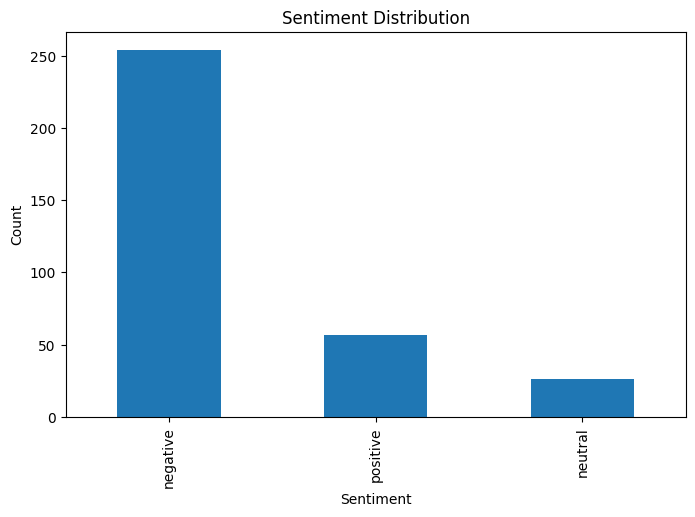

In [11]:
import matplotlib.pyplot as plt

sentiment_counts = df["sentiment"].value_counts()
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind="bar")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()

In [21]:
# Save results to a new CSV file
df.to_csv("news_sentiment_results.csv", index=False)

print("Sentiment analysis complete. Results saved to 'news_sentiment_results.csv'.")

Sentiment analysis complete. Results saved to 'news_sentiment_results.csv'.
